# Introduction

We've been doing text classification 📖 with just **one input** for every target, be it [binary](https://www.kaggle.com/code/wesleyacheng/movie-review-sentiment-classifier-with-bert) or [multiclass](https://www.kaggle.com/code/wesleyacheng/news-topic-classification-with-bert) or [multilabel](https://www.kaggle.com/code/wesleyacheng/hate-speech-multilabel-classification-with-bert). The fun thing about most real-world 🌎 problems are that they usually have **multiple inputs**. 

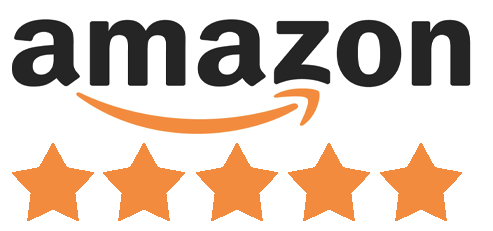

For example, in order to **classify a Amazon product review** 📦, we can not only use the **review content**, but we can include the **review title** as well. Having **multiple inputs** allows the model to **better understand the context** in which it is used, while usually **increasing or having similar performance** to that of a single input 😮. One can also add **too many inputs** model that may cause a **substantial reduction** in performance, especially if the truncation of each input context is **severe** like reducing a sentence the first word 😢. **But in general, combining/concatenating inputs are a useful deep learning 🤖  technique to have in your arsenal 🛡.**

In this notebook, we will be, as hinted above 🙃, classifying product review sentiment using both the review title **AND** content! 😁

**Results TLDR:** Review Title + Review Content > Review Content > Review Title

# Setup Libraries

In [1]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate torchinfo matplotlib nltk wordcloud tqdm --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate|^torchinfo|^matplotlib|^nltk|^wordcloud|^tqdm'

datasets==2.1.0
evaluate==0.4.0
matplotlib==3.7.1
matplotlib-inline @ file:///home/conda/feedstock_root/build_artifacts/matplotlib-inline_1660814786464/work
matplotlib-venn==0.11.9
nltk==3.2.4
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=de0c947f8c06a637392b3efa76aad3ac1d91effd6481f8154aeeb4303f12d133
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=178c0fd167dd56970d14aa26ff4e98d8963ead026f00b4f36d6d7fc93421f317
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==1.0.0
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=89c1e3cb8aa36dc34a82501799a7d364ca4a4f6d447d86324a9aec7036fa4702
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=4ed53c3d788b3394127da0e3207891e604d52f3b7ea69e5be0a895cc6029ed4a
tqdm @ file:///home/conda/feedstock_root/build_artifacts/tqdm_1677948868469/work
transformers==4.28.1
wordcloud==1.9.2


# Create Training Dataset

## Clone Dataset

In [2]:
from datasets import load_dataset

# let's clone the dataset from HuggingFace Hub
# source: https://huggingface.co/datasets/amazon_polarity
raw_datasets = load_dataset('amazon_polarity')
raw_datasets

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset amazon_polarity downloaded and prepared to /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [3]:
# let's checkout a raw example
print(f"RAW EXAMPLE:\n{raw_datasets['train'][0]}")

RAW EXAMPLE:
{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [4]:
# let's get the label information
NUM_LABELS = raw_datasets['train'].features['label'].num_classes
ID2LABEL = {}
LABEL2ID = {}

for idx, label in enumerate(raw_datasets['train'].features['label'].names):
    ID2LABEL[idx] = label.upper()
    LABEL2ID[label.upper()] = idx
    
print(f"NUM_LABELS: {NUM_LABELS}")
print(f"ID2LABEL: {ID2LABEL}")
print(f"LABEL2ID: {LABEL2ID}")

NUM_LABELS: 2
ID2LABEL: {0: 'NEGATIVE', 1: 'POSITIVE'}
LABEL2ID: {'NEGATIVE': 0, 'POSITIVE': 1}


## Split Dataset to Train/Validation/Test

In [5]:
import torch
import numpy as np

# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
from datasets import DatasetDict

# make train test split 
# note: we reduced the dataset by 100 to speed up training
_train_val_datasets = raw_datasets['train'].train_test_split(test_size=0.1, seed=SEED, shuffle=True)
split_datasets = DatasetDict({
    'train': _train_val_datasets['train'].select(range(_train_val_datasets['train'].num_rows//100)),
    'val': _train_val_datasets['test'].select(range(_train_val_datasets['test'].num_rows//100)),
    'test': raw_datasets['test'].select(range(raw_datasets['test'].num_rows//100)),
})

split_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 32400
    })
    val: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 4000
    })
})

In [7]:
# let's checkout an example
print(f"SPLIT EXAMPLE:\n{split_datasets['train'][0]}")

SPLIT EXAMPLE:
{'label': 1, 'title': 'Kick Ass!!!!! I loved it!!!!!', 'content': "This book is my Bible!! I have been a huge fan for years, and I thought the life of a rock star would be perfect. Boy did this book change my mind! These guys ROCK and this book explains in detail just how hard this band has actually had to struggle to make it in the music buisness. However, it is filled with very explicit details that I wouldn't reccomend for a young child. >:("}


## Exploratory Data Analysis

In [8]:
from collections import Counter

counters = {
    'total': Counter(),
    'train': Counter(),
    'val': Counter(),
    'test': Counter(),
}
for split_type in split_datasets.keys():
    counters[split_type].update(split_datasets[split_type]['label'])
    counters['total'].update(split_datasets[split_type]['label'])
    
counters

{'total': Counter({0: 20009, 1: 19991}),
 'train': Counter({0: 16244, 1: 16156}),
 'val': Counter({0: 1814, 1: 1786}),
 'test': Counter({1: 2049, 0: 1951})}

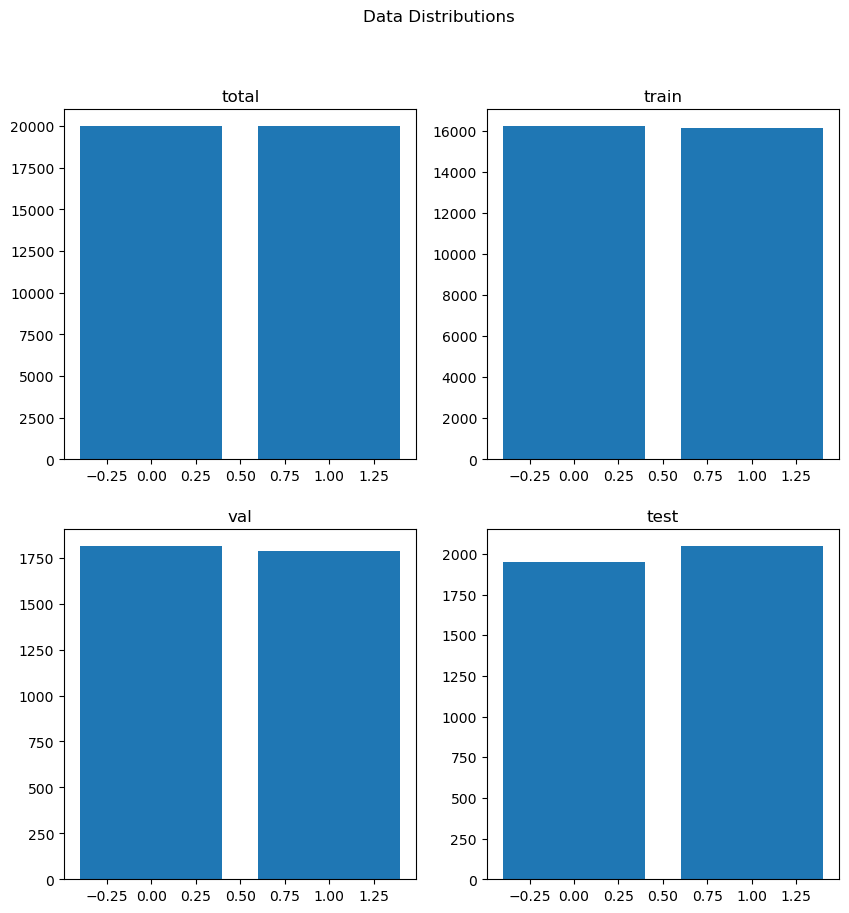

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# let's plot the data distribution to see if there is an imbalance
# all splits look like they are 50-50
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.suptitle('Data Distributions')
for ax, (split_type,split_counter) in zip(axs.flat, counters.items()):
    ax.set_title(split_type)
    ax.bar(split_counter.keys(), split_counter.values())
    
plt.show()

In [10]:
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from tqdm.notebook import tqdm

# let's all the words from both review title and content
stopwords_set = set(stopwords.words('english')).union(STOPWORDS)

title_counters = {'POSITIVE': Counter(), 'NEGATIVE': Counter()}
content_counters = {'POSITIVE': Counter(), 'NEGATIVE': Counter()}
for split_type in split_datasets.keys():
    for example in tqdm(split_datasets[split_type]):
        # we do a lowercasing, remove stopwords, and remove any punctuations
        title_word_list = list(filter(lambda x: x.isalpha() and x not in stopwords_set, map(lambda x: x.lower(), wordpunct_tokenize(example['title']))))
        content_word_list = list(filter(lambda x: x.isalpha() and x not in stopwords_set, map(lambda x: x.lower(), wordpunct_tokenize(example['title']))))
        if example['label'] == 1:
            title_counters['POSITIVE'].update(title_word_list)
            content_counters['POSITIVE'].update(content_word_list)
        else:
            title_counters['NEGATIVE'].update(title_word_list)
            content_counters['NEGATIVE'].update(content_word_list)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  0%|          | 0/32400 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [11]:
# we define a function to generate a wordcloud based on their frequencies
# the higher the frequency of word, the bigger it is in the word cloud
# we are capping the words to 100 to improve visibility
def plot_wordcloud(word_counter, title):
    wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(frequencies=word_counter)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

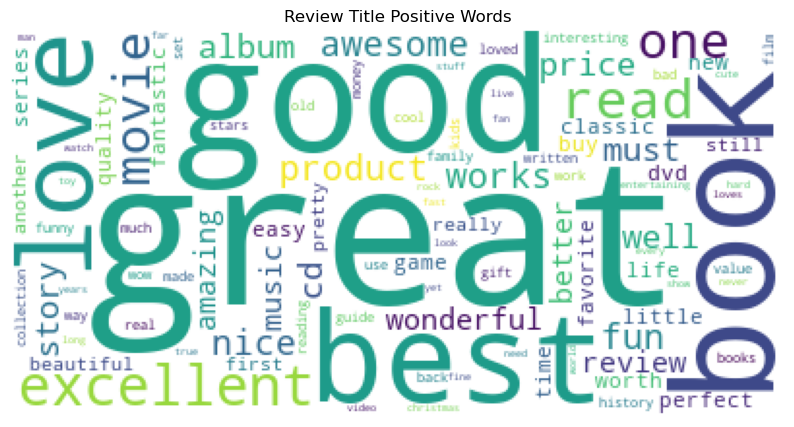

None

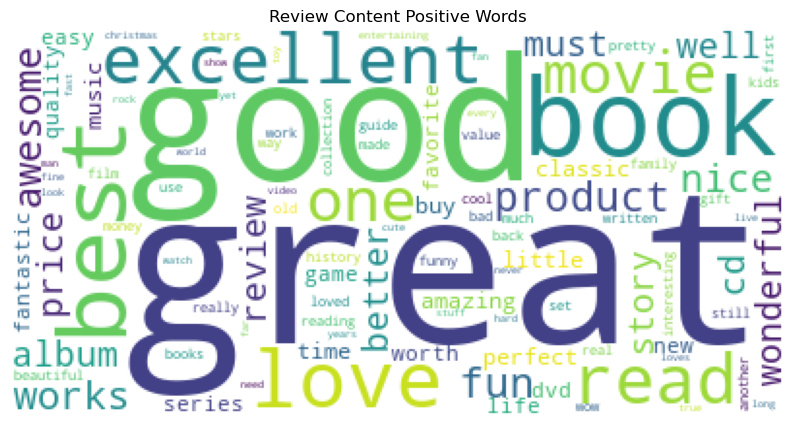

None

In [12]:
# let's plot the wordcloud for review title and content positive counters
display(plot_wordcloud(word_counter=title_counters['POSITIVE'], title='Review Title Positive Words'))
display(plot_wordcloud(word_counter=content_counters['POSITIVE'], title='Review Content Positive Words'))

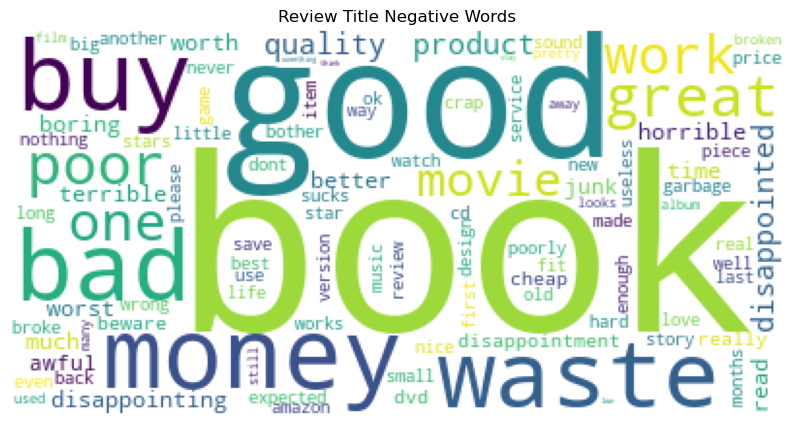

None

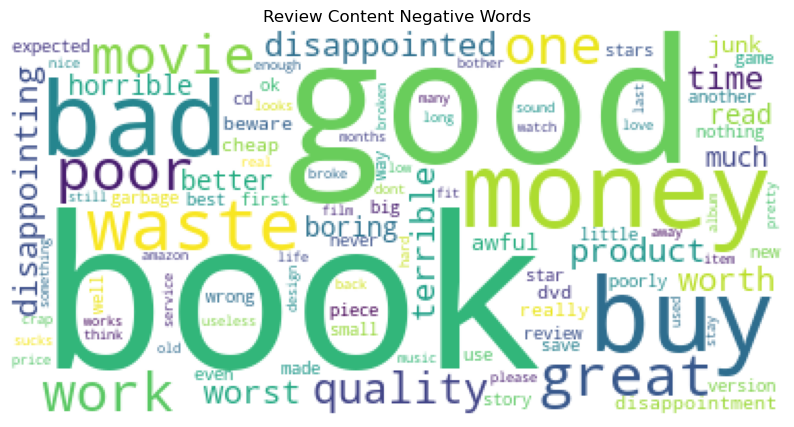

None

In [13]:
# let's plot the wordcloud for review title and content negative counters
# it's make sense the world's largest bookstore will be mostly about books XD
display(plot_wordcloud(word_counter=title_counters['NEGATIVE'], title='Review Title Negative Words'))
display(plot_wordcloud(word_counter=content_counters['NEGATIVE'], title='Review Content Negative Words'))

# Clone Tokenizer

In [14]:
from transformers import AutoTokenizer

CHECKPOINT = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

# Train with only Review Title

In [15]:
# let's tokenize only the review title
title_tokenized_datasets = split_datasets.rename_columns({'label':'labels'})
title_tokenized_datasets = title_tokenized_datasets.map(lambda batch: tokenizer(batch['title'], truncation=True), batched=True, remove_columns=['title','content'])
title_tokenized_datasets

  0%|          | 0/33 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 32400
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3600
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})

In [16]:
# let's see an example of the tokenized text
print(f"TOKENIZED_EXAMPLE:\n{title_tokenized_datasets['train'][0]}")

TOKENIZED_EXAMPLE:
{'labels': 1, 'input_ids': [101, 5926, 4632, 999, 999, 999, 999, 999, 1045, 3866, 2009, 999, 999, 999, 999, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
from transformers import AutoModelForSequenceClassification
from torchinfo import summary

# we clone the pre-trained model from HuggingFace Hub
# source: https://huggingface.co/distilbert-base-uncased
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)

# let's print out the model architecture
display(model)

# let's print out the number of parameters
summary(model)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

In [18]:
import evaluate

# we use accuracy and f1 as measure of binary classification
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

In [19]:
from transformers import TrainingArguments, Trainer

# setup training configurations for all models
# we will be training in 3 epochs and evaluation after each,
# also keeping the model with lowest validation loss
training_args = TrainingArguments(
    seed=SEED,
    output_dir='results',
    optim='adamw_torch',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    report_to='none',
)

# we will keep the running results here for plotting later
results = {'title': {}, 'content': {}, 'title_content': {}}

In [20]:
# we reinitialize the model
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)

# also reinitialize the trainer with the new model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=title_tokenized_datasets['train'],
    eval_dataset=title_tokenized_datasets['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

### Train Model

In [21]:
# let's get the unfine-tuned test performance
trainer.evaluate(title_tokenized_datasets['test'])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.69225013256073,
 'eval_accuracy': 0.52275,
 'eval_f1': 0.5180509972229235,
 'eval_runtime': 3.7299,
 'eval_samples_per_second': 1072.425,
 'eval_steps_per_second': 16.891}

In [22]:
# let's train the model
results['title']['train_metrics'] = trainer.train().metrics

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.347900,0.336046,0.855000,0.855801
2,0.228300,0.360237,0.855278,0.856197
3,0.143200,0.432778,0.853889,0.853726


In [23]:
# let's get the metrics of the model with lowest validation loss
results['title']['val_metrics'] = trainer.evaluate()
print(results['title']['val_metrics'])

{'eval_loss': 0.33604568243026733, 'eval_accuracy': 0.855, 'eval_f1': 0.8558011049723757, 'eval_runtime': 1.6308, 'eval_samples_per_second': 2207.552, 'eval_steps_per_second': 34.953, 'epoch': 3.0}


In [24]:
# let's get fine-tuned test performance
results['title']['test_metrics'] = trainer.evaluate(title_tokenized_datasets['test'])
print(results['title']['test_metrics'])

{'eval_loss': 0.32965245842933655, 'eval_accuracy': 0.85575, 'eval_f1': 0.8612647270978601, 'eval_runtime': 2.0495, 'eval_samples_per_second': 1951.688, 'eval_steps_per_second': 30.739, 'epoch': 3.0}


Performance seems pretty decent even with just the review title. That would make sense given that the review title is just a summary of the review content.

# Train with only Review Content

In [25]:
# let's tokenize only the review content
content_tokenized_datasets = split_datasets.rename_columns({'label':'labels'})
content_tokenized_datasets = content_tokenized_datasets.map(lambda batch: tokenizer(batch['content'], truncation=True), batched=True, remove_columns=['title','content'])
content_tokenized_datasets

  0%|          | 0/33 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 32400
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3600
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})

In [26]:
# let's see an example of the tokenized text
print(f"TOKENIZED_EXAMPLE:\n{content_tokenized_datasets['train'][0]}")

TOKENIZED_EXAMPLE:
{'labels': 1, 'input_ids': [101, 2023, 2338, 2003, 2026, 6331, 999, 999, 1045, 2031, 2042, 1037, 4121, 5470, 2005, 2086, 1010, 1998, 1045, 2245, 1996, 2166, 1997, 1037, 2600, 2732, 2052, 2022, 3819, 1012, 2879, 2106, 2023, 2338, 2689, 2026, 2568, 999, 2122, 4364, 2600, 1998, 2023, 2338, 7607, 1999, 6987, 2074, 2129, 2524, 2023, 2316, 2038, 2941, 2018, 2000, 5998, 2000, 2191, 2009, 1999, 1996, 2189, 20934, 2483, 2791, 1012, 2174, 1010, 2009, 2003, 3561, 2007, 2200, 13216, 4751, 2008, 1045, 2876, 1005, 1056, 28667, 9006, 10497, 2005, 1037, 2402, 2775, 1012, 1028, 1024, 1006, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


### Setup Model and Trainer

In [27]:
# we reinitialize the model
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)

# also reinitialize the trainer with the new model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=content_tokenized_datasets['train'],
    eval_dataset=content_tokenized_datasets['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

### Train Model

In [28]:
# let's get the unfine-tuned test performance
trainer.evaluate(content_tokenized_datasets['test'])

{'eval_loss': 0.698199450969696,
 'eval_accuracy': 0.51225,
 'eval_f1': 0.6774673499752025,
 'eval_runtime': 15.8555,
 'eval_samples_per_second': 252.278,
 'eval_steps_per_second': 3.973}

In [29]:
# let's train the model
results['content']['train_metrics'] = trainer.train().metrics

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.237900,0.189833,0.927778,0.928216
2,0.115000,0.180665,0.935556,0.935770
3,0.054900,0.219198,0.940278,0.939590


In [30]:
# let's get the metrics of the model with lowest validation loss
results['content']['val_metrics'] = trainer.evaluate()
print(results['content']['val_metrics'])

{'eval_loss': 0.18066497147083282, 'eval_accuracy': 0.9355555555555556, 'eval_f1': 0.9357696566998893, 'eval_runtime': 14.4308, 'eval_samples_per_second': 249.467, 'eval_steps_per_second': 3.95, 'epoch': 3.0}


In [31]:
# let's get fine-tuned test performance
results['content']['test_metrics'] = trainer.evaluate(content_tokenized_datasets['test'])
print(results['content']['test_metrics'])

{'eval_loss': 0.20657941699028015, 'eval_accuracy': 0.9285, 'eval_f1': 0.93125, 'eval_runtime': 15.7835, 'eval_samples_per_second': 253.428, 'eval_steps_per_second': 3.991, 'epoch': 3.0}


# Train with both Review Title and Content

## How Tokenizer Tokenize and Splits Two Texts

In [32]:
# let's take an example
example = split_datasets['train'][0]
print(f"EXAMPLE: {example}")

EXAMPLE: {'label': 1, 'title': 'Kick Ass!!!!! I loved it!!!!!', 'content': "This book is my Bible!! I have been a huge fan for years, and I thought the life of a rock star would be perfect. Boy did this book change my mind! These guys ROCK and this book explains in detail just how hard this band has actually had to struggle to make it in the music buisness. However, it is filled with very explicit details that I wouldn't reccomend for a young child. >:("}


In [33]:
# let's look at how the tokenizer tokenizes the title
    # we tokenize it by breaking the sentence into word splits
title_tokens = tokenizer.tokenize(example['title'])
print(f"TITLE TOKENS: {title_tokens}\n")
    # let's print out number of tokens
title_length = len(title_tokens)
print(f"TITLE LENGTH: {title_length}\n")
    # let's convert them to ids used by the embedding layer
title_ids = tokenizer.convert_tokens_to_ids(title_tokens)
print(f"TITLE IDS: {title_ids}\n")
    # let's decode our encode sentence to see if we get back our sentence
decoded_title = tokenizer.decode(title_ids)
print(f"DECODED TITLE: {decoded_title}\n")

TITLE TOKENS: ['kick', 'ass', '!', '!', '!', '!', '!', 'i', 'loved', 'it', '!', '!', '!', '!', '!']

TITLE LENGTH: 15

TITLE IDS: [5926, 4632, 999, 999, 999, 999, 999, 1045, 3866, 2009, 999, 999, 999, 999, 999]

DECODED TITLE: kick ass!!!!! i loved it!!!!!



In [34]:
# let's look at how the tokenizer tokenizes the content
    # we tokenize it by breaking the sentence into word splits
content_tokens = tokenizer.tokenize(example['content'])
print(f"CONTENT TOKENS: {content_tokens}\n")
    # let's print out number of tokens
content_length = len(content_tokens)
print(f"CONTENT LENGTH: {content_length}\n")
    # let's convert them to ids used by the embedding layer
content_ids = tokenizer.convert_tokens_to_ids(content_tokens)
print(f"CONTENT IDS: {content_ids}\n")
    # let's decode our encoded sentence to see if we get back our sentence
decoded_content = tokenizer.decode(content_ids)
print(f"DECODED CONTENT: {decoded_content}\n")

CONTENT TOKENS: ['this', 'book', 'is', 'my', 'bible', '!', '!', 'i', 'have', 'been', 'a', 'huge', 'fan', 'for', 'years', ',', 'and', 'i', 'thought', 'the', 'life', 'of', 'a', 'rock', 'star', 'would', 'be', 'perfect', '.', 'boy', 'did', 'this', 'book', 'change', 'my', 'mind', '!', 'these', 'guys', 'rock', 'and', 'this', 'book', 'explains', 'in', 'detail', 'just', 'how', 'hard', 'this', 'band', 'has', 'actually', 'had', 'to', 'struggle', 'to', 'make', 'it', 'in', 'the', 'music', 'bu', '##is', '##ness', '.', 'however', ',', 'it', 'is', 'filled', 'with', 'very', 'explicit', 'details', 'that', 'i', 'wouldn', "'", 't', 'rec', '##com', '##end', 'for', 'a', 'young', 'child', '.', '>', ':', '(']

CONTENT LENGTH: 91

CONTENT IDS: [2023, 2338, 2003, 2026, 6331, 999, 999, 1045, 2031, 2042, 1037, 4121, 5470, 2005, 2086, 1010, 1998, 1045, 2245, 1996, 2166, 1997, 1037, 2600, 2732, 2052, 2022, 3819, 1012, 2879, 2106, 2023, 2338, 2689, 2026, 2568, 999, 2122, 4364, 2600, 1998, 2023, 2338, 7607, 1999, 69

In [35]:
# let's look at how the tokenizer tokenizes two texts, the title and content
    # I use max_length as 10 to show how the tokenizer equally divides the two texts
    # although, the length of both texts is higher than 5 from above, the tokenizer truncates them both equally to 5 tokens
    # in the training, the tokens will be [CLS] <tokens of title> [SEP] <tokens of content> [SEP]
tokenized_example = tokenizer.tokenize(example['title'], example['content'], truncation=True, max_length=10)
tokenized_example

['kick', 'ass', '!', '!', '!', 'this', 'book', 'is', 'my', 'bible']

## Let's train with review title and content as inputs

### Tokenize Dataset

In [45]:
# let's tokenize both the title and content
title_content_tokenized_datasets = split_datasets.rename_columns({'label':'labels'})
# there seem's to be some caching by Kaggle in this line, make sure the tokenized example below has two 102 tokens 
title_content_tokenized_datasets = title_content_tokenized_datasets.map(lambda batch: tokenizer(batch['title'], batch['content'], truncation=True), batched=True, remove_columns=['title','content'])
title_content_tokenized_datasets

  0%|          | 0/33 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 32400
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3600
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})

In [46]:
# let's see an example of the tokenized text
print(f"TOKENIZED_EXAMPLE:\n{title_content_tokenized_datasets['train'][0]}")

TOKENIZED_EXAMPLE:
{'labels': 1, 'input_ids': [101, 5926, 4632, 999, 999, 999, 999, 999, 1045, 3866, 2009, 999, 999, 999, 999, 999, 102, 2023, 2338, 2003, 2026, 6331, 999, 999, 1045, 2031, 2042, 1037, 4121, 5470, 2005, 2086, 1010, 1998, 1045, 2245, 1996, 2166, 1997, 1037, 2600, 2732, 2052, 2022, 3819, 1012, 2879, 2106, 2023, 2338, 2689, 2026, 2568, 999, 2122, 4364, 2600, 1998, 2023, 2338, 7607, 1999, 6987, 2074, 2129, 2524, 2023, 2316, 2038, 2941, 2018, 2000, 5998, 2000, 2191, 2009, 1999, 1996, 2189, 20934, 2483, 2791, 1012, 2174, 1010, 2009, 2003, 3561, 2007, 2200, 13216, 4751, 2008, 1045, 2876, 1005, 1056, 28667, 9006, 10497, 2005, 1037, 2402, 2775, 1012, 1028, 1024, 1006, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Setup Model and Trainer

In [47]:
# we reinitialize the model
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID)

# also reinitialize the trainer with the new model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=title_content_tokenized_datasets['train'],
    eval_dataset=title_content_tokenized_datasets['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

### Train Model

In [48]:
# let's get the unfine-tuned test performance
trainer.evaluate(title_content_tokenized_datasets['test'])

{'eval_loss': 0.6981186270713806,
 'eval_accuracy': 0.51225,
 'eval_f1': 0.6774673499752025,
 'eval_runtime': 16.3577,
 'eval_samples_per_second': 244.533,
 'eval_steps_per_second': 3.851}

In [49]:
# let's train the model
results['title_content']['train_metrics'] = trainer.train().metrics

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.202000,0.165231,0.937778,0.938764
2,0.091000,0.172365,0.943611,0.943564
3,0.040900,0.216901,0.944444,0.943820


In [50]:
# let's get the metrics of the model with lowest validation loss
results['title_content']['val_metrics'] = trainer.evaluate()
print(results['title_content']['val_metrics'])

{'eval_loss': 0.16523076593875885, 'eval_accuracy': 0.9377777777777778, 'eval_f1': 0.9387643521049754, 'eval_runtime': 14.9235, 'eval_samples_per_second': 241.23, 'eval_steps_per_second': 3.819, 'epoch': 3.0}


In [51]:
# let's get fine-tuned test performance
results['title_content']['test_metrics'] = trainer.evaluate(title_content_tokenized_datasets['test'])
print(results['title_content']['test_metrics'])

{'eval_loss': 0.16848763823509216, 'eval_accuracy': 0.935, 'eval_f1': 0.9386792452830188, 'eval_runtime': 16.4645, 'eval_samples_per_second': 242.947, 'eval_steps_per_second': 3.826, 'epoch': 3.0}


# Compare Results

- We see from all metrics that using just the review content is better than using just the review title, which make sense as the content provides richer contextual information.
- We also see from all metrics that using both review title and content is better than both by themselves, which make sense again as having more context is usually better.

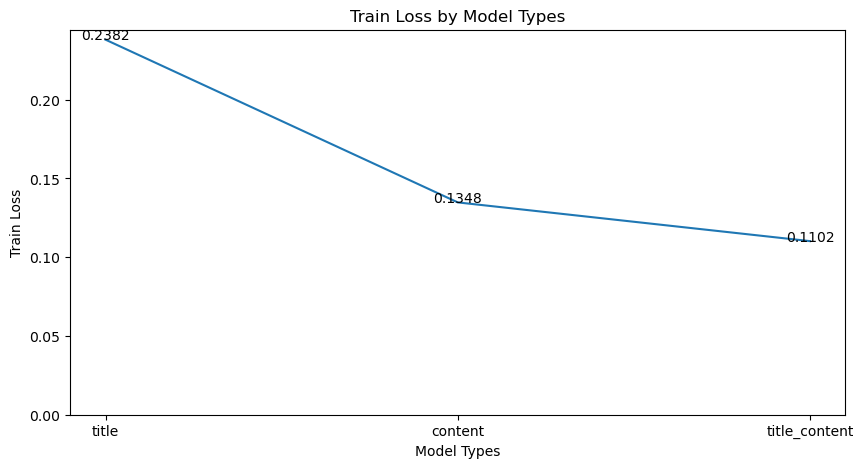

In [52]:
# get results
name_list = []
results_list = []
for name in results:
    name_list.append(name)
    results_list.append(float(f"{results[name]['train_metrics']['train_loss']:.4f}"))
    
# plot graph
xlabel = 'Model Types'
ylabel = 'Train Loss'
fig, axs = plt.subplots(nrows=1, figsize=(10,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

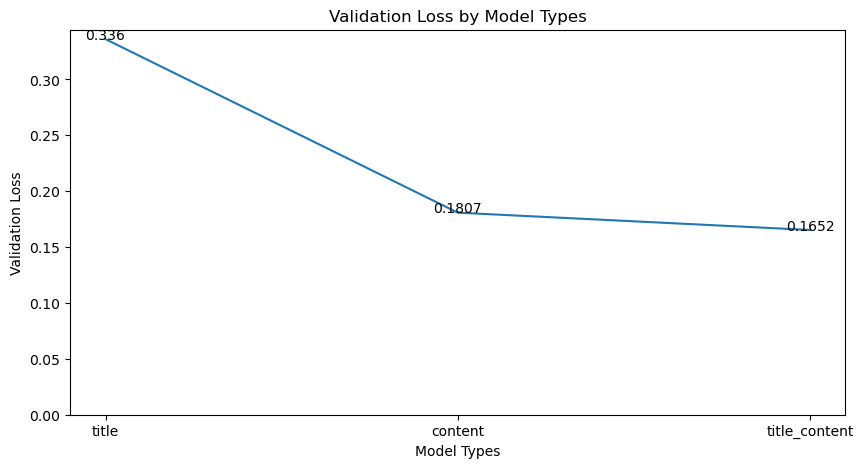

In [53]:
# get results
name_list = []
results_list = []
for name in results:
    name_list.append(name)
    results_list.append(float(f"{results[name]['val_metrics']['eval_loss']:.4f}"))
    
# plot graph
xlabel = 'Model Types'
ylabel = 'Validation Loss'
fig, axs = plt.subplots(nrows=1, figsize=(10,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

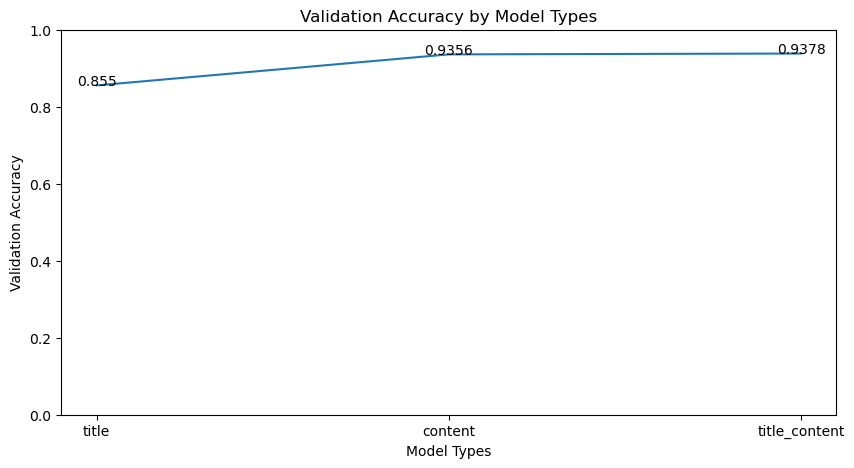

In [54]:
# get results
name_list = []
results_list = []
for name in results:
    name_list.append(name)
    results_list.append(float(f"{results[name]['val_metrics']['eval_accuracy']:.4f}"))
    
# plot graph
xlabel = 'Model Types'
ylabel = 'Validation Accuracy'
fig, axs = plt.subplots(nrows=1, figsize=(10,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

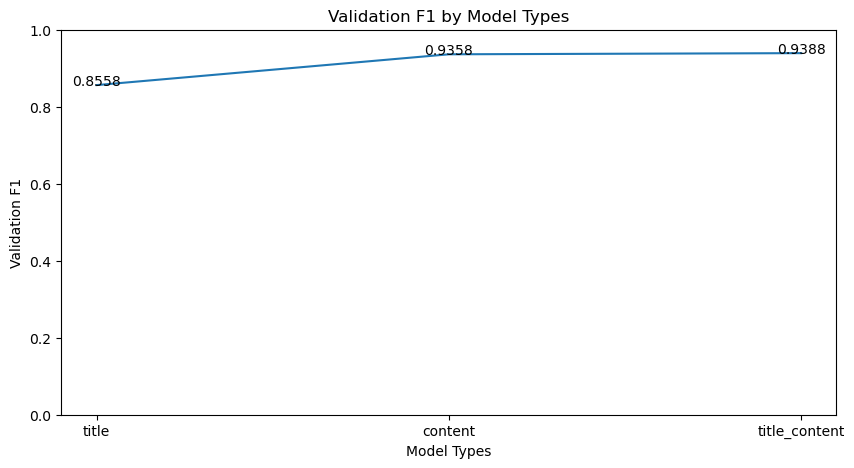

In [55]:
# get results
name_list = []
results_list = []
for name in results:
    name_list.append(name)
    results_list.append(float(f"{results[name]['val_metrics']['eval_f1']:.4f}"))
    
# plot graph
xlabel = 'Model Types'
ylabel = 'Validation F1'
fig, axs = plt.subplots(nrows=1, figsize=(10,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

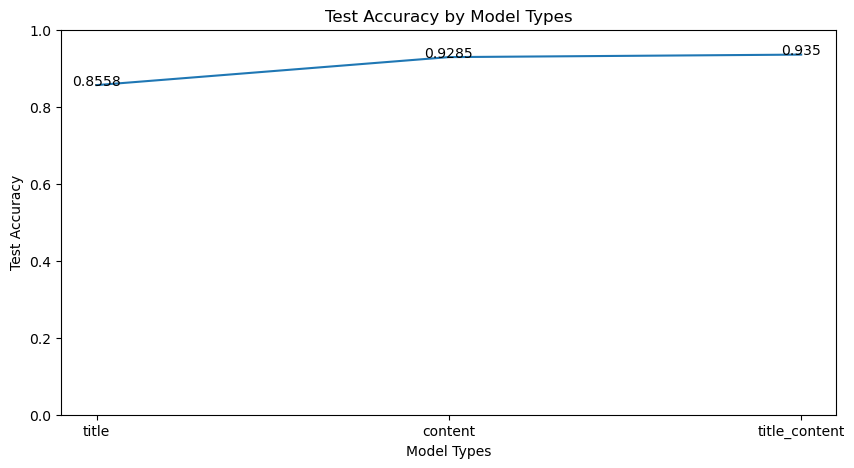

In [56]:
# get results
name_list = []
results_list = []
for name in results:
    name_list.append(name)
    results_list.append(float(f"{results[name]['test_metrics']['eval_accuracy']:.4f}"))
    
# plot graph
xlabel = 'Model Types'
ylabel = 'Test Accuracy'
fig, axs = plt.subplots(nrows=1, figsize=(10,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

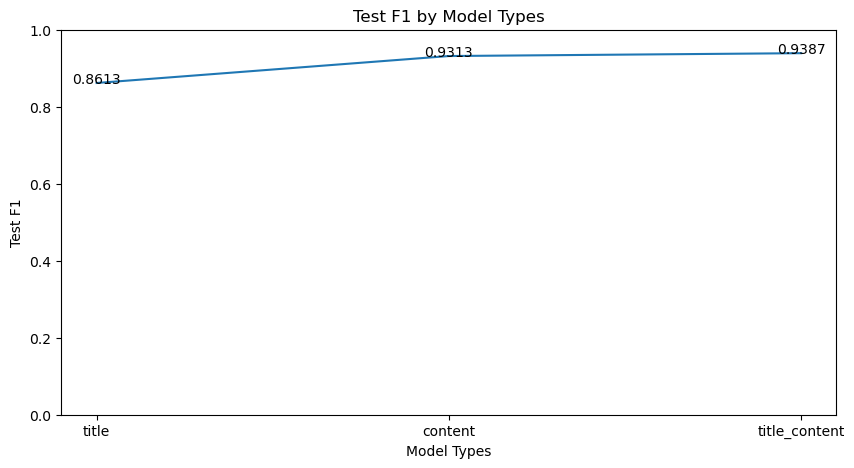

In [57]:
# get results
name_list = []
results_list = []
for name in results:
    name_list.append(name)
    results_list.append(float(f"{results[name]['test_metrics']['eval_f1']:.4f}"))
    
# plot graph
xlabel = 'Model Types'
ylabel = 'Test F1'
fig, axs = plt.subplots(nrows=1, figsize=(10,5))
axs.set(xlabel=xlabel, ylabel=ylabel)
axs.set_title(f"{ylabel} by {xlabel}")
axs.plot(name_list, results_list)
axs.set_ylim(0,1)
for i in range(len(results_list)):
    axs.text(x=i, y=results_list[i], s=results_list[i], ha='center')

# Let's try out some examples

We will be using the model that is trained on both Amazon Review Title and Content.

We will be taking examples from the Amazon Reviews in HuggingFace's 🤗 book: [Natural Language Processing with Transformers](https://www.amazon.com/Natural-Language-Processing-Transformers-Revised/dp/1098136799).

In [63]:
# move model back to cpu
print(f"OLD_DEVICE: {model.device}")
model.to('cpu')
print(f"NEW_DEVICE: {model.device}")

OLD_DEVICE: cuda:0
NEW_DEVICE: cpu


In [64]:
# let's get a positive review
# source: https://www.amazon.com/gp/customer-reviews/RS9LPLL6SHKR0
amazon_review_title = """
First chapter already paid off
"""
amazon_review_content = """
Need not look further, must have, absolutely the best, etc. Just buy this when you are a data scientist and into NLP. Sure, by all means buy more learning material. This one you won’t regret.
"""

inputs = tokenizer(amazon_review_title, amazon_review_content, truncation=True, return_tensors='pt')
output = model(**inputs)
output_probs = output.logits.sigmoid()
output_label_id = torch.argmax(output_probs)
output_label = ID2LABEL[output_label_id.item()]
output_label, output_probs[:,output_label_id].item()

('POSITIVE', 0.7938211560249329)

In [65]:
# let's get a negative review
# source: https://www.amazon.com/gp/customer-reviews/RSZRPPNA7B3A8
amazon_review_title = """
Good content: poor print quality
"""
amazon_review_content = """
Content is well-written and a useful introductory piece of material for Transformers. Print quality is abysmal, I received the product brand-new two days ago and chapter 1 is falling apart while I’m reading it! Incredibly disappointing.
"""

inputs = tokenizer(amazon_review_title, amazon_review_content, truncation=True, return_tensors='pt')
output = model(**inputs)
output_probs = output.logits.sigmoid()
output_label_id = torch.argmax(output_probs)
output_label = ID2LABEL[output_label_id.item()]
output_label, output_probs[:,output_label_id].item()

('NEGATIVE', 0.6890285015106201)